#### Let's take a look at the data

In [1]:
import pandas as pd

In [2]:
URM_path = "data_train.csv"
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path,
                                sep=",",
                                # header=None,
                                dtype={0:int, 1:int, 2:int},
                                engine='python')

URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction"]

In [3]:
URM_all_dataframe.head(10)

,UserID,ItemID,Interaction
0,1,7,1
1,1,15,1
2,1,16,1
3,1,133,1
4,1,161,1
5,1,187,1
6,1,205,1
7,1,222,1
8,1,237,1
9,1,354,1


In [4]:
print ("The number of interactions is {}".format(len(URM_all_dataframe)))

The number of interactions is 146814


### Now we can extract the list of unique user id and item id and display some statistics

In [5]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

In [6]:
n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))

Number of items	 19802, Number of users	 3826
Max ID items	 22347, Max Id users	 3931



### See that the max ID of items and users is higher than the number of unique values -> empty profiles
### We should remove empty indices, to do so we create a new mapping

In [9]:
mapped_id, original_id = pd.factorize(URM_all_dataframe["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(URM_all_dataframe["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

URM_all_dataframe["UserID"] = URM_all_dataframe["UserID"].map(user_original_ID_to_index)
URM_all_dataframe["ItemID"] = URM_all_dataframe["ItemID"].map(item_original_ID_to_index)
URM_all_dataframe.head(10)

,UserID,ItemID,Interaction
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
5,0,5,1
6,0,6,1
7,0,7,1
8,0,8,1
9,0,9,1


In [10]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 19802, Number of users	 3826
Max ID items	 19801, Max Id users	 3825

Average interactions per user 38.37
Average interactions per item 7.41

Sparsity 99.81 %


#### To store the data we use a sparse matrix. We build it as a COO matrix and then change its format

#### The COO constructor expects (data, (row, column))

In [12]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((URM_all_dataframe["Interaction"].values,
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)))

URM_all

<3826x19802 sparse matrix of type '<class 'numpy.int64'>'
	with 146814 stored elements in COOrdinate format>

In [13]:
URM_all.tocsr()

<3826x19802 sparse matrix of type '<class 'numpy.int64'>'
	with 146814 stored elements in Compressed Sparse Row format>

### We compute the item popularity as the number of interaction in each column

### We can use the properties of sparse matrices in CSC format

In [14]:
import numpy as np

item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity

array([449, 323, 232, ...,   1,   1,   1], dtype=int32)

In [15]:
item_popularity = np.sort(item_popularity)
item_popularity

array([  1,   1,   1, ..., 500, 537, 600], dtype=int32)

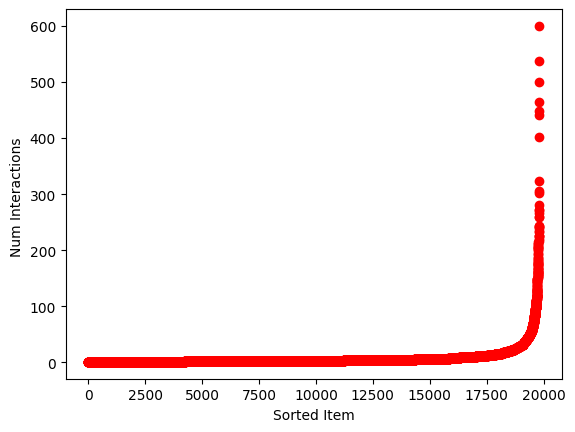

In [18]:
import matplotlib.pyplot as pyplot
pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [19]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 7.41
Average per-item interactions for the top 10% popular items 41.54
Average per-item interactions for the least 10% popular items 1.00
Average per-item interactions for the median 10% popular items 3.00


In [20]:
print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Number of items with zero interactions 0


### We compute the user activity (profile length) as the number of interaction in each row

### We can use the properties of sparse matrices in CSR format

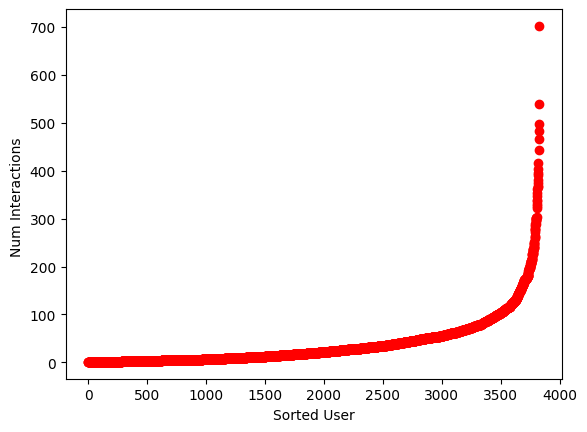

In [21]:
user_activity = np.ediff1d(URM_all.tocsr().indptr)
user_activity = np.sort(user_activity)


pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted User')
pyplot.show()

In order to evaluate our recommender we have to define:

A splitting of the data in URM_train and URM_test
An evaluation metric
A functon computing the evaluation for each user
The splitting of the data is very important to ensure your algorithm is evaluated in a realistic scenario by using test it has never seen. We create two splits:

- Train data: we will use this to train our model

- Test data: we will use this to evaluate our model

In [22]:
train_test_split = 0.80

n_interactions = URM_all.nnz


train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])
train_mask

array([ True, False,  True, ...,  True,  True,  True])

In [23]:
URM_train = sps.csr_matrix((URM_all.data[train_mask],
                            (URM_all.row[train_mask], URM_all.col[train_mask])))

URM_train

<3826x19802 sparse matrix of type '<class 'numpy.int64'>'
	with 117515 stored elements in Compressed Sparse Row format>

In [24]:
test_mask = np.logical_not(train_mask)

URM_test = sps.csr_matrix((URM_all.data[test_mask],
                            (URM_all.row[test_mask], URM_all.col[test_mask])))

URM_test

<3826x19796 sparse matrix of type '<class 'numpy.int64'>'
	with 29299 stored elements in Compressed Sparse Row format>

### Evaluation metric
### Precision: how many of the recommended items are relevant

In [26]:
def precision(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)

    return precision_score

def AP(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

####Let's build the recommender